## Recurrent Neural Networks (RNN's)

RNN: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

**Note** : It is a part of Day 29 NLP.

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df_shuffled = train_df.sample(frac=1, random_state=42) 
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

### Text vectorization (tokenization)


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

text_vectorizer = TextVectorization(max_tokens=None,  
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None)

In [16]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Now let's create another `TextVectorization` object using our custom parameters.

In [17]:
max_vocab_length = 10000 
max_length = 15 
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
text_vectorizer.adapt(train_sentences)

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

### Getting a baseline


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Steps of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).



###  LSTM

we're going to add an LSTM layer between our embedding and output.


In [49]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [50]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [52]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230526-001518
Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.5074 - accuracy: 0.7460 - val_loss: 0.4590 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3168 - accuracy: 0.8716 - val_loss: 0.5119 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2198 - accuracy: 0.9155 - val_loss: 0.5876 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1577 - accuracy: 0.9442 - val_loss: 0.5923 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1108 - accuracy: 0.9577 - val_loss: 0.8550 - val_accuracy: 0.7559


In [53]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 2ms/step


((762, 1),
 array([[0.00630066],
        [0.7862389 ],
        [0.9991792 ],
        [0.06841089],
        [0.00448257],
        [0.99932086],
        [0.8617405 ],
        [0.99968505],
        [0.9993248 ],
        [0.57989997]], dtype=float32))

In [54]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.59055118110236,
 'precision': 0.7567160722556739,
 'recall': 0.7559055118110236,
 'f1': 0.7539595513230887}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.


In [57]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [60]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230526-001539
Epoch 1/5
215/215 [==============================] - 11s 43ms/step - loss: 0.5274 - accuracy: 0.7231 - val_loss: 0.4539 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3179 - accuracy: 0.8686 - val_loss: 0.4850 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2149 - accuracy: 0.9187 - val_loss: 0.5544 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1517 - accuracy: 0.9488 - val_loss: 0.6279 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1145 - accuracy: 0.9609 - val_loss: 0.6063 - val_accuracy: 0.7756


Due to the optimized default settings of the GRU cell in TensorFlow, training doesn't take long at all. 

Time to make some predictions on the validation samples.

In [61]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


((762, 1),
 array([[0.31703022],
        [0.9160779 ],
        [0.9977792 ],
        [0.14830083],
        [0.01086212],
        [0.9908326 ],
        [0.6938264 ],
        [0.9978917 ],
        [0.99662066],
        [0.4299642 ]], dtype=float32))

In [62]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [63]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'precision': 0.776326889347514,
 'recall': 0.7755905511811023,
 'f1': 0.7740902496040959}

### Bidirectonal RNN model 

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.


In [65]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [66]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [68]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230526-001559
Epoch 1/5
215/215 [==============================] - 14s 47ms/step - loss: 0.5096 - accuracy: 0.7447 - val_loss: 0.4585 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3140 - accuracy: 0.8726 - val_loss: 0.5086 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2139 - accuracy: 0.9183 - val_loss: 0.5716 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1486 - accuracy: 0.9504 - val_loss: 0.6707 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1058 - accuracy: 0.9648 - val_loss: 0.6658 - val_accuracy: 0.7677


In [69]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.05258294],
       [0.8495521 ],
       [0.99898857],
       [0.15441437],
       [0.00566462],
       [0.99576193],
       [0.952807  ],
       [0.9993511 ],
       [0.99936384],
       [0.19425693]], dtype=float32)

In [70]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

## Convolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, Use 1-dimensional convolution instead of a 2-dimensional convolution.


### Conv1D


In [73]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [74]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01675646, -0.03352517,  0.04817378, ..., -0.02946043,
          -0.03770737,  0.01220698],
         [-0.00607298,  0.06020833, -0.05641982, ...,  0.08325578,
          -0.01878556, -0.08398241],
         [-0.0362346 ,  0.00904451, -0.03833614, ...,  0.0051756 ,
          -0.00220015, -0.0017492 ],
         ...,
         [-0.01078545,  0.05590528,  0.03125916, ..., -0.0312557 ,
          -0.05340781, -0.03800201],
         [-0.01078545,  0.05590528,  0.03125916, ..., -0.0312557 ,
          -0.05340781, -0.03800201],
         [-0.01078545,  0.05590528,  0.03125916, ..., -0.0312557 ,
          -0.05340781, -0.03800201]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.10975833, 0.        , 0.        , 0.        ,
          0.06834612, 0.        , 0.02298634, 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.06889185,
          0.08162662, 0.

In [75]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [76]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230526-001626
Epoch 1/5
215/215 [==============================] - 11s 42ms/step - loss: 0.5693 - accuracy: 0.7108 - val_loss: 0.4736 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3426 - accuracy: 0.8600 - val_loss: 0.4677 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2130 - accuracy: 0.9202 - val_loss: 0.5374 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1366 - accuracy: 0.9564 - val_loss: 0.6076 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0958 - accuracy: 0.9667 - val_loss: 0.6706 - val_accuracy: 0.7874


Nice! Thanks to GPU acceleration, our 1D convolutional model trains nice and fast. Let's make some predictions with it and evaluate them just as before.

In [77]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.7295443 ],
       [0.63939744],
       [0.9997949 ],
       [0.05865377],
       [0.0070557 ],
       [0.99556965],
       [0.90180606],
       [0.9973731 ],
       [0.99953437],
       [0.6327795 ]], dtype=float32)

In [78]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.74015748031496,
 'precision': 0.7900609457201325,
 'recall': 0.7874015748031497,
 'f1': 0.7852275674790494}

## transfer learning for NLP



In [81]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01154496  0.02487099  0.0287963  -0.01272263  0.03969951  0.08829075
  0.02682647  0.05582222 -0.01078761 -0.00596655  0.00640638 -0.01816132
  0.0002885   0.09106605  0.05874373 -0.03175148  0.01510153 -0.05164852
  0.0099434  -0.06867751 -0.04210396  0.0267539   0.03008907  0.00320448
 -0.00336865 -0.04790529  0.02267517 -0.00984557 -0.04066692 -0.01285528
 -0.04665243  0.05630673 -0.03952145  0.00521895  0.02495948 -0.07011835
  0.02873133  0.04945794 -0.00634555 -0.08959357  0.02807156 -0.00809173
 -0.01363956  0.05998395 -0.1036155  -0.05192674  0.00232459 -0.02326531
 -0.03752431  0.0333298 ], shape=(50,), dtype=float32)


In [82]:
embed_samples[0].shape

TensorShape([512])

In [83]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [84]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [85]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230526-001739
Epoch 1/5
215/215 [==============================] - 6s 11ms/step - loss: 0.5014 - accuracy: 0.7870 - val_loss: 0.4469 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4145 - accuracy: 0.8140 - val_loss: 0.4359 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4000 - accuracy: 0.8216 - val_loss: 0.4319 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3927 - accuracy: 0.8262 - val_loss: 0.4280 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3862 - accuracy: 0.8288 - val_loss: 0.4299 - val_accuracy: 0.8176


In [86]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.14814094],
       [0.74057853],
       [0.9886474 ],
       [0.22455953],
       [0.7404941 ],
       [0.6678845 ],
       [0.98305696],
       [0.9746391 ],
       [0.923527  ],
       [0.08624077]], dtype=float32)

In [87]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8206021490415145,
 'recall': 0.8175853018372703,
 'f1': 0.8158792847350168}

### TensorFlow Hub Pretrained Sentence Encoder 10% of the training data


In [91]:

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [92]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [93]:

pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [94]:
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the layout of `model_7` is the same as `model_6`. Now Training the newly created model on 10% training data subset.

In [95]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230526-001758
Epoch 1/5
22/22 [==============================] - 4s 41ms/step - loss: 0.6671 - accuracy: 0.6997 - val_loss: 0.6443 - val_accuracy: 0.7415
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5895 - accuracy: 0.8309 - val_loss: 0.5846 - val_accuracy: 0.7467
Epoch 3/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5116 - accuracy: 0.8382 - val_loss: 0.5336 - val_accuracy: 0.7677
Epoch 4/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4492 - accuracy: 0.8411 - val_loss: 0.5040 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4080 - accuracy: 0.8469 - val_loss: 0.4880 - val_accuracy: 0.7703


In [96]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.24178001],
       [0.8116845 ],
       [0.91511923],
       [0.32094172],
       [0.587357  ],
       [0.82938445],
       [0.8401675 ],
       [0.8496708 ],
       [0.8371127 ],
       [0.14010696]], dtype=float32)

In [97]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7760118694840564,
 'recall': 0.7703412073490814,
 'f1': 0.7665375100103654}

## Combining models (model ensembling/stacking)

Many use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is **uncorrelated**, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

Since It's a classification problem, there are a few of ways to combine models:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict `[1, 0, 1]` respectively, the majority class is `1`, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.


In [106]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [107]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 77.95275590551181,
 'precision': 0.7792442137914578,
 'recall': 0.7795275590551181,
 'f1': 0.7789463852322546}

In [108]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [109]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

## Saving and loading a trained model


In [111]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [112]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [113]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 7ms/step - loss: 0.4299 - accuracy: 0.8176


[0.4298648238182068, 0.817585289478302]

Calling the `save()` method on target model and passing it a filepath allows to save model in the `SavedModel` format. 

In [114]:
# Save TF Hub Sentence Encoder model to SavedModel format
model_6.save("model_6_SavedModel_format")

In [115]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [116]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4299 - accuracy: 0.8176


[0.4298648238182068, 0.817585289478302]

## Finding the most wrong examples


In [117]:
# Creatinng dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.148141
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.740579
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988647
3,@camilacabello97 Internally and externally scr...,1,0.0,0.224560
4,Radiation emergency #preparedness starts with ...,1,1.0,0.740494


In [118]:
# Finding the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.906832
628,@noah_anyname That's where the concentration c...,0,1.0,0.866348
759,FedEx will no longer transport bioterror patho...,0,1.0,0.859502
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.855963
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.839930
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.815515
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.807973
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.806746
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782425
695,A look at state actions a year after Ferguson'...,0,1.0,0.759534



* `0` = Not a real diaster Tweet
* `1` = Real diaster Tweet

In [119]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): 
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9068315625190735
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8663479685783386
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.859502375125885
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8559632897377014
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8399295806884766
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8155148029327393
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pro

In [120]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06247330829501152
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.05949299782514572
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.056083984673023224
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.055036477744579315
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.054454777389764786
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.046157706528902054
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03960023820400238
Text:
Why are you deluged with low self-im

## Making predictions on the test dataset


In [121]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) 
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 79ms/step
Pred: 0, Prob: 0.05416637659072876
Text:
WHAT a day's cricket that was. Has destroyed any plans I had for exercise today.

----

1/1 [==============================] - 0s 39ms/step
Pred: 1, Prob: 0.5330829620361328
Text:
Any other generation this would've been fatality  http://t.co/zcCtZM9f0o

----

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.9940084218978882
Text:
Arson suspect linked to 30 fires caught in Northern California http://t.co/HkFPyNb4PS

----

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.9726524353027344
Text:
Help support the victims of the Japanese Earthquake and Pacific Tsunami http://t.co/O5GbPBQH http://t.co/MN5wnxf0 #hope4japan #pray4japan

----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.36651405692100525
Text:
this is from my show last night and im still panicking over the fact i saw sweaty ashton with my own two eyes http://t.co/yyJ76WBC9y

## Predicting on Tweets from the wild


In [122]:
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [123]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [124]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 39ms/step
Pred: 0.0 (not real disaster) Prob: 0.044768452644348145
Text:
Life like an ensemble: take the best choices from others and make your own


In [125]:
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [126]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 42ms/step
Pred: 1.0 (real disaster) Prob: 0.9650391936302185
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [127]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 40ms/step
Pred: 1.0 (real disaster) Prob: 0.9686568379402161
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Looks like model is performing as expected, predicting both of the diaster Tweets as actual diasters.


## The speed/score tradeoff

One of the final tests is to do is to find the speed/score tradeoffs between best model and baseline model.


In [128]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [129]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.2243557769999711, 0.0002944301535432692)

In [130]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.013254724999967493, 1.739465223092847e-05)

It seems with current hardware, best performing model takes over 10x the time to make predictions as baseline model.


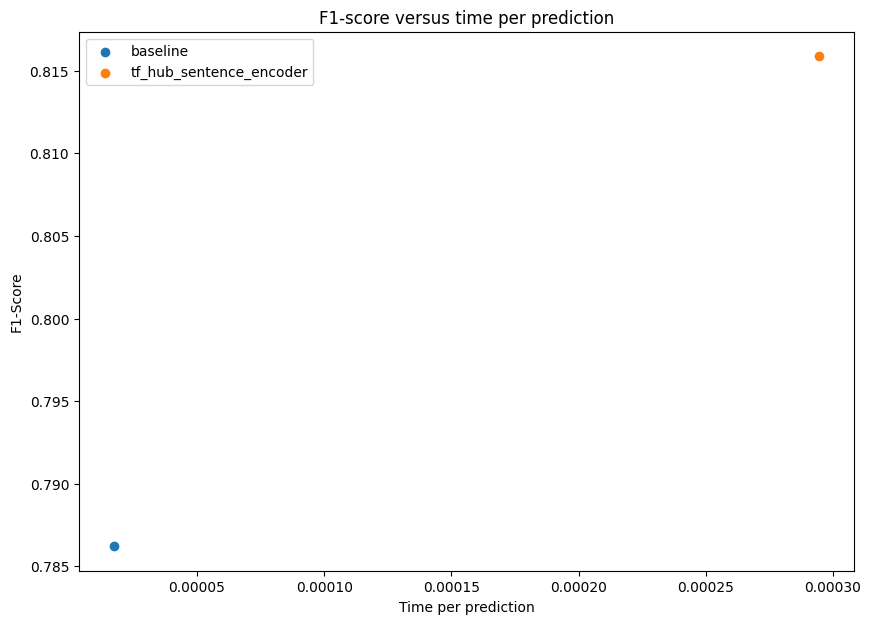

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");